<a href="https://colab.research.google.com/github/Mokshasood/GAN/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
from tensorflow.keras import layers
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [0]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, input_shape=(100,))) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same')) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    
    return model

In [0]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
def gan(generator,discriminator):
    discriminator.trainable=False
    model=tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [0]:
generator=generator_model()
discriminator = discriminator_model()
discriminator.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
d_gan=gan(generator,discriminator)
d_gan.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [0]:
batch_size=128
epochs=50
noise_dim=100

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5

11493376/11490434 [==============================] - 1s 0us/step


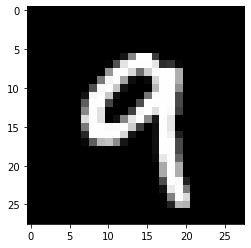

In [10]:
plt.imshow(x_train[110].reshape((28,28)) , cmap = 'gray')

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator,
                                 discriminator=discriminator)

In [0]:
D_loss=[]
G_loss=[]
def train(epochs, BATCH_SIZE):
    n_batches = int(x_train.shape[0] // BATCH_SIZE)
    #print('Batches per epoch:', n_batches)
    
    for epoch in range(epochs):

      #print ('Epoch:',epoch+1)
        
      for i in range(n_batches):  
        image_batch = x_train[np.random.randint(0, x_train.shape[0], size=BATCH_SIZE)]

        noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))

        generated_images = generator.predict(noise)
        X = np.concatenate((image_batch, generated_images))

        Y = np.zeros(2*BATCH_SIZE)
        Y[:BATCH_SIZE] = 0.9

        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, Y)

        noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
        Y2 = np.ones(BATCH_SIZE)
        discriminator.trainable = False
        g_loss = d_gan.train_on_batch(noise, Y2)
      D_loss.append(d_loss)
      G_loss.append(g_loss)
      #print ('Generator Loss:',g_loss,"Discriminator Loss:",d_loss)
      

      imgs = 8
      x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(imgs, noise_dim)))
      if (epoch+1)%10 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

      for k in range(imgs):
          plt.subplot(2, 4, k+1)
          plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
          plt.xticks([])
          plt.yticks([])
      plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
      #plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


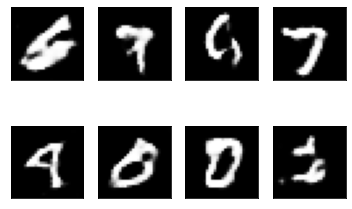

In [13]:
train(epochs,batch_size)

Text(0, 0.5, 'Loss')

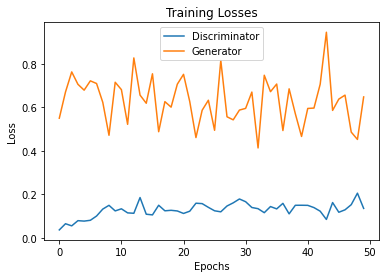

In [20]:
dis=[]
gen=[]
for i in range(len(D_loss)):
  dis.append(D_loss[i][0])
  gen.append(G_loss[i][0])
plt.plot(range(epochs),dis,label='Discriminator')
plt.plot(range(epochs),gen,label='Generator')
plt.legend()
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')